In [1]:
# Generic
import typing
import os
from pathlib import Path
import typing
import json

# Plotting
import matplotlib.pyplot as plt

# Numerical Computing
import numpy as np
import torch

# muutils
from zanj.zanj import ZANJ, ZANJ_GLOBAL_DEFAULTS

# Our Code
from muutils.nbutils.configure_notebook import configure_notebook
from maze_transformer.training.config import ConfigHolder, ZanjHookedTransformer, BaseGPTConfig, TrainConfig
from maze_dataset import MazeDataset, MazeDatasetConfig
from maze_dataset.dataset.configs import MAZE_DATASET_CONFIGS
from maze_dataset.generation import LatticeMazeGenerators
from maze_transformer.training.train_model import TrainingResult, train_model
from maze_transformer.training.wandb_logger import WandbProject


In [2]:
# set global defaults for ZANJ
ZANJ_GLOBAL_DEFAULTS.external_array_threshold = 1024
ZANJ_GLOBAL_DEFAULTS.external_list_threshold = 1024

# paths
PATH_EXAMPLES: Path = Path("../examples/")
PATH_DATA: Path = Path("../data/")

# reproducibility and device
DEVICE = configure_notebook(seed=42, dark_mode=True)
print(f"{DEVICE = }")

set up plots with PLOT_MODE = 'inline', FIG_OUTPUT_FMT = None, FIG_BASEPATH = None
DEVICE = device(type='cuda')


# 1. Train the model according to the config

In [3]:
print(f"{list(MAZE_DATASET_CONFIGS.keys()) = }")

# if you want to specify a custom config, you can do so here
CFG_CUSTOM: ConfigHolder = ConfigHolder(
    name = "custom",
    dataset_cfg = MazeDatasetConfig(
		name="custom-dataset",
		grid_n=4,
		n_mazes=100,
		maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(
          do_forks=False,
        ),
        applied_filters=[{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}],
        seq_len_max=256,
        seq_len_min=3,
	),
    model_cfg = BaseGPTConfig(
        name="custom-model",
        act_fn="gelu",
        d_model=64,
        d_head=16,
        n_layers=4,
    ),
    train_cfg = TrainConfig(
        name="custom-train",
        optimizer=torch.optim.AdamW,
        optimizer_kwargs=dict(lr=0.003),
        batch_size=16,
        num_epochs=30,
        dataloader_cfg=dict(
            shuffle=True,
            num_workers=8,
            drop_last=False,
        ),
        intervals_count=dict(
            print_loss=100,
            checkpoint=10,
            eval_fast=10,
            eval_slow=10,
        ),
        validation_dataset_cfg=10,

    ),
)


list(MAZE_DATASET_CONFIGS.keys()) = ['test-g3-n5-a_dfs-h75556', 'demo_small-g3-n100-a_dfs-h88371', 'demo-g6-n10K-a_dfs-h30615']


In [4]:

CFG_HALLWAY: ConfigHolder = ConfigHolder(
    name = "hallway_vLeon",
    dataset_cfg = MazeDatasetConfig(
		name="hallway_vLeon",
		grid_n=4,
		n_mazes=100,
		maze_ctor=LatticeMazeGenerators.gen_dfs,
        maze_ctor_kwargs=dict(
            do_forks=False,
        ),
        applied_filters=[{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}],
        seq_len_max=256,
        seq_len_min=3,
	),
    model_cfg = BaseGPTConfig(
        name="custom-model",
        act_fn="gelu",
        d_model=128,
        d_head=32,
        n_layers=6,
    ),
    train_cfg = TrainConfig(
        name="custom-train",
        optimizer=torch.optim.AdamW,
        optimizer_kwargs=dict(lr=0.0003),
        batch_size=8,
        num_epochs=20,
        dataloader_cfg=dict(
            shuffle=True,
            num_workers=8,
            drop_last=False,
        ),
        intervals_count=dict(
            print_loss=100,
            checkpoint=20,
            eval_fast=100,
            eval_slow=50,
        ),
        validation_dataset_cfg=10,
    ),
)

In [5]:
# here is where to specify which config to actually use
CFG: ConfigHolder = CFG_HALLWAY

In [6]:
print(json.dumps(CFG.summary(), indent=2))

{
  "name": "hallway_vLeon",
  "dataset_cfg": {
    "name": "hallway_vLeon",
    "fname": "hallway_vLeon-g4-n100-a_dfs-h68834",
    "sdc_hash": 89288119908456752243824986153286303445629986205359491044775293231766844468834,
    "seed": 42,
    "seq_len_min": 3,
    "seq_len_max": 256,
    "applied_filters": [
      {
        "name": "collect_generation_meta",
        "args": [],
        "kwargs": {}
      }
    ],
    "grid_n": 4,
    "grid_shape": [
      4,
      4
    ],
    "n_mazes": 100,
    "maze_ctor_name": "gen_dfs",
    "maze_ctor_kwargs": {
      "do_forks": false
    }
  },
  "model_cfg": {
    "name": "custom-model",
    "act_fn": "gelu",
    "d_model": 128,
    "d_head": 32,
    "n_layers": 6,
    "weight_processing": {
      "are_layernorms_folded": false,
      "are_weights_processed": false
    },
    "n_heads": 4
  },
  "train_cfg": {
    "name": "custom-train",
    "optimizer": "AdamW",
    "optimizer_kwargs": {
      "lr": 0.0003
    },
    "batch_size": 8,
    "data

In [7]:
# get just the dataset, generating it if needed. 
# This step can be skipped if you set `do_generate_dataset=True` when calling `train_model`
# or if the dataset in question already exists

# load the dataset
DATASET: MazeDataset = MazeDataset.from_config(CFG.dataset_cfg, verbose=True, local_base_path=PATH_DATA)
print("len dataset", len(DATASET))

trying to get the dataset 'hallway_vLeon-g4-n100-a_dfs-h68834'
loading dataset from ../data/hallway_vLeon-g4-n100-a_dfs-h68834.zanj
Got dataset hallway_vLeon with 100 items. output.cfg.to_fname() = 'hallway_vLeon-g4-n100-a_dfs-h68834'
len dataset 100


In [12]:
result: TrainingResult = train_model(
	base_path=PATH_DATA,
    cfg=CFG,
	wandb_project=WandbProject.DEMO_NOTEBOOKS, # change this to WandbProject.DEMO_NOTEBOOKS!
	do_generate_dataset=False,
	dataset_verbose=True,
    dataset=DATASET,
)

2024-02-01 17:40:23 ERROR Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: watermelontology. Use `wandb login --relogin` to force relogin


2024-02-01 17:40:25 INFO config ={'__format__': 'ConfigHolder(SerializableDataclass)', 'dataset_cfg': {'__format__': 'MazeDatasetConfig(SerializableDataclass)', 'name': 'hallway_vLeon', 'seq_len_min': 3, 'seq_len_max': 256, 'seed': 42, 'applied_filters': [{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}], 'grid_n': 4, 'n_mazes': 100, 'maze_ctor': {'__name__': 'gen_dfs', '__module__': 'maze_dataset.generation.generators', '__doc__': ['generate a lattice maze using depth first search, iterative', '', '        # Arguments', '        - `grid_shape: Coord`: the shape of the grid', '        - `lattice_dim: int`: the dimension of the lattice', '          (default: `2`)', '        - `accessible_cells: int | float |None`: the number of accessible cells in the maze. If `None`, defaults to the total number of cells in the grid. if a float, asserts it is <= 1 and treats it as a proportion of **total cells**', '            (default: `None`)', '        - `max_tree_depth: int | float | N

/home/feynman/Documents_Linux/unsearch/maze-transformer/maze_transformer/evaluation/path_evals.py:99: RuntimeWarning:

fraction_connections_adjacent_lattice called on path of length less than 2, retuning NaN
prediction = array([[1, 1]])



2024-02-01 17:40:28 INFO Running evals: eval_slow
2024-02-01 17:40:30 INFO iteration 0/12: loss=3.838
2024-02-01 17:40:30 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_0.zanj
2024-02-01 17:40:30 INFO Running evals: eval_slow
2024-02-01 17:40:32 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_1.zanj
2024-02-01 17:40:32 INFO Running evals: eval_slow
2024-02-01 17:40:34 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_2.zanj
2024-02-01 17:40:34 INFO Running evals: eval_slow
2024-02-01 17:40:36 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_3.zanj
2024-02-01 17:40:36 INFO Running evals: eval_slow
2024-02-01 17:40:38 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_4.zanj
2024-02-01 17:40:39 INFO Running evals: eval_slow
2024-02-01 17:40:40 INFO Sav

/home/feynman/Documents_Linux/unsearch/maze-transformer/maze_transformer/evaluation/path_evals.py:99: RuntimeWarning:

fraction_connections_adjacent_lattice called on path of length less than 2, retuning NaN
prediction = array([[2, 0]])



2024-02-01 17:40:54 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_11.zanj
epoch = 1, num_epochs = 20
2024-02-01 17:40:55 INFO Running evals: eval_fast


/home/feynman/Documents_Linux/unsearch/maze-transformer/maze_transformer/evaluation/path_evals.py:99: RuntimeWarning:

fraction_connections_adjacent_lattice called on path of length less than 2, retuning NaN
prediction = array([[1, 2]])



2024-02-01 17:40:56 INFO Running evals: eval_slow
2024-02-01 17:40:58 INFO iteration 0/12: loss=1.991
2024-02-01 17:40:58 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_0.zanj
2024-02-01 17:40:58 INFO Running evals: eval_slow
2024-02-01 17:41:00 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_1.zanj
2024-02-01 17:41:01 INFO Running evals: eval_slow
2024-02-01 17:41:02 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_2.zanj
2024-02-01 17:41:03 INFO Running evals: eval_slow
2024-02-01 17:41:04 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_3.zanj
2024-02-01 17:41:05 INFO Running evals: eval_slow
2024-02-01 17:41:06 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_4.zanj
2024-02-01 17:41:07 INFO Running evals: eval_slow


/home/feynman/Documents_Linux/unsearch/maze-transformer/maze_transformer/evaluation/path_evals.py:99: RuntimeWarning:

fraction_connections_adjacent_lattice called on path of length less than 2, retuning NaN
prediction = array([[2, 3]])



2024-02-01 17:41:08 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_5.zanj
2024-02-01 17:41:09 INFO Running evals: eval_slow
2024-02-01 17:41:11 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_6.zanj
2024-02-01 17:41:11 INFO Running evals: eval_slow
2024-02-01 17:41:13 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_7.zanj
2024-02-01 17:41:13 INFO Running evals: eval_slow
2024-02-01 17:41:15 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_8.zanj
2024-02-01 17:41:15 INFO Running evals: eval_slow
2024-02-01 17:41:17 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_9.zanj
2024-02-01 17:41:17 INFO Running evals: eval_slow
2024-02-01 17:41:19 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_10.zanj
2024-

/home/feynman/Documents_Linux/unsearch/maze-transformer/maze_transformer/evaluation/path_evals.py:99: RuntimeWarning:

fraction_connections_adjacent_lattice called on path of length less than 2, retuning NaN
prediction = array([[2, 1]])



2024-02-01 17:41:25 INFO Running evals: eval_slow
2024-02-01 17:41:27 INFO iteration 0/12: loss=1.678
2024-02-01 17:41:27 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_0.zanj
2024-02-01 17:41:27 INFO Running evals: eval_slow
2024-02-01 17:41:29 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_1.zanj
2024-02-01 17:41:29 INFO Running evals: eval_slow
2024-02-01 17:41:31 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_2.zanj
2024-02-01 17:41:31 INFO Running evals: eval_slow
2024-02-01 17:41:33 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_3.zanj
2024-02-01 17:41:33 INFO Running evals: eval_slow
2024-02-01 17:41:35 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_4.zanj
2024-02-01 17:41:35 INFO Running evals: eval_slow
2024-02-01 17:41:37 INFO Sav

/home/feynman/Documents_Linux/unsearch/maze-transformer/maze_transformer/evaluation/path_evals.py:99: RuntimeWarning:

fraction_connections_adjacent_lattice called on path of length less than 2, retuning NaN
prediction = array([[0, 0]])



2024-02-01 17:41:56 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_2.zanj
2024-02-01 17:41:57 INFO Running evals: eval_slow
2024-02-01 17:41:58 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_3.zanj
2024-02-01 17:41:59 INFO Running evals: eval_slow
2024-02-01 17:42:00 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_4.zanj
2024-02-01 17:42:00 INFO Running evals: eval_slow
2024-02-01 17:42:02 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_5.zanj
2024-02-01 17:42:02 INFO Running evals: eval_slow
2024-02-01 17:42:04 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_6.zanj
2024-02-01 17:42:04 INFO Running evals: eval_slow
2024-02-01 17:42:05 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_7.zanj
2024-0

/home/feynman/Documents_Linux/unsearch/maze-transformer/maze_transformer/evaluation/path_evals.py:99: RuntimeWarning:

fraction_connections_adjacent_lattice called on path of length less than 2, retuning NaN
prediction = array([[0, 2]])



2024-02-01 17:42:18 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_1.zanj
2024-02-01 17:42:19 INFO Running evals: eval_slow
2024-02-01 17:42:20 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_2.zanj
2024-02-01 17:42:21 INFO Running evals: eval_slow
2024-02-01 17:42:23 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_3.zanj
2024-02-01 17:42:23 INFO Running evals: eval_slow
2024-02-01 17:42:24 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_4.zanj
2024-02-01 17:42:25 INFO Running evals: eval_slow
2024-02-01 17:42:26 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_5.zanj
2024-02-01 17:42:27 INFO Running evals: eval_slow
2024-02-01 17:42:28 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_6.zanj
2024-0

/home/feynman/Documents_Linux/unsearch/maze-transformer/maze_transformer/evaluation/path_evals.py:99: RuntimeWarning:

fraction_connections_adjacent_lattice called on path of length less than 2, retuning NaN
prediction = array([[1, 0]])



2024-02-01 17:42:40 INFO Running evals: eval_slow
2024-02-01 17:42:41 INFO iteration 0/12: loss=1.102
2024-02-01 17:42:41 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_0.zanj
2024-02-01 17:42:41 INFO Running evals: eval_slow
2024-02-01 17:42:43 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_1.zanj
2024-02-01 17:42:43 INFO Running evals: eval_slow
2024-02-01 17:42:44 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_2.zanj
2024-02-01 17:42:45 INFO Running evals: eval_slow
2024-02-01 17:42:46 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_3.zanj
2024-02-01 17:42:47 INFO Running evals: eval_slow
2024-02-01 17:42:48 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_4.zanj
2024-02-01 17:42:49 INFO Running evals: eval_slow
2024-02-01 17:42:50 INFO Sav

/home/feynman/Documents_Linux/unsearch/maze-transformer/maze_transformer/evaluation/path_evals.py:99: RuntimeWarning:

fraction_connections_adjacent_lattice called on path of length less than 2, retuning NaN
prediction = array([[2, 2]])



2024-02-01 17:43:34 INFO Running evals: eval_slow
2024-02-01 17:43:35 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_4.zanj
2024-02-01 17:43:36 INFO Running evals: eval_slow
2024-02-01 17:43:37 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_5.zanj
2024-02-01 17:43:38 INFO Running evals: eval_slow
2024-02-01 17:43:39 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_6.zanj
2024-02-01 17:43:39 INFO Running evals: eval_slow
2024-02-01 17:43:41 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_7.zanj
2024-02-01 17:43:41 INFO Running evals: eval_slow
2024-02-01 17:43:43 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-02-01-17-40-23/checkpoints/model.iter_8.zanj
2024-02-01 17:43:43 INFO Running evals: eval_slow
2024-02-01 17:43:45 INFO Saving model checkpoint to ../data/hallway_vLeon_2024-0

# 2. Evaluate how good the model is

In [16]:
import pandas as pd
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_transformer.evaluation.eval_model import predict_maze_paths
from maze_transformer.evaluation.path_evals import rollout_evals
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS, LatticeMazeGenerators, CoordArray


## 2.1 Get evaluation statistics:

In [17]:
def evaluate_model_rollouts(
    model,
    dataset: MazeDataset,
    rollouts_acc: int|None = None,
    rollout_temperature: float = 0.0,
    batch_size: int|None = 16,
) -> dict[str, float]:


    tokenizer: MazeTokenizer = model.zanj_model_config.maze_tokenizer

    if rollouts_acc is not None:
        if rollouts_acc == "all":
            rollouts_acc = len(dataset)
            print(f"number of rollouts = {rollouts_acc}")
        dataset_tokens: list[list[str]] = dataset.as_tokens(maze_tokenizer=tokenizer)[:rollouts_acc]
        # do rollouts
        predictions: list[list[str|tuple[int, int]]] = predict_maze_paths(
            tokens_batch=dataset_tokens,
            data_cfg=dataset.cfg,
            model=model,
            max_new_tokens=None,
            temperature=rollout_temperature,
            when_noncoord="include",
            smart_max_new_tokens=True,
            batch_size=batch_size,
        )

        mazes: list[SolvedMaze] = dataset.mazes[:rollouts_acc]
        assert len(predictions) == len(mazes)

        # evaluate rollouts
        rollout_eval_results: dict[str, float] = rollout_evals(
            predictions=predictions,
            mazes=mazes,
        )

        return rollout_eval_results

    return {}

In [19]:
RESULTS: pd.DataFrame = evaluate_model_rollouts(
	model=result.model,
	dataset=DATASET,
	rollouts_acc="all", # number of mazes to check
	batch_size=10, 
)

print(RESULTS)

number of rollouts = 90
{'correct EOS': 1.0, 'mean invalid tokens': 0.06666666666666667, 'percent with invalid tokens': 0.022222222222222254, 'exactly correct rollouts': 0.0, 'valid rollouts': 0.37777777777777777, 'rollouts with target reached': 0.15555555555555556}


In [ ]:
model = result.model
dataset =DATASET
tokenizer: MazeTokenizer = model.zanj_model_config.maze_tokenizer
dataset_tokens: list[list[str]] = dataset.as_tokens(maze_tokenizer=tokenizer)
print(" ".join(dataset_tokens[0]))


<ADJLIST_START> (1,0) <--> (1,1) ; (1,1) <--> (1,2) ; (0,1) <--> (0,0) ; (0,2) <--> (0,1) ; (1,2) <--> (0,2) ; (1,0) <--> (2,0) ; <ADJLIST_END> <ORIGIN_START> (1,1) <ORIGIN_END> <TARGET_START> (1,2) <TARGET_END> <PATH_START> (1,1) (1,2) <PATH_END>


<ADJLIST_START> (1,0) <--> (0,0) ; (0,2) <--> (1,2) ; (1,2) <--> (2,2) ; (1,1) <--> (1,0) ; (1,4) <--> (1,3) ; (4,0) <--> (3,0) ; (2,0) <--> (2,1) ; (0,2) <--> (0,3) ; (3,1) <--> (3,2) ; (0,3) <--> (1,3) ; (4,4) <--> (3,4) ; (4,3) <--> (4,4) ; (4,2) <--> (4,3) ; (3,0) <--> (2,0) ; (1,4) <--> (0,4) ; (3,4) <--> (2,4) ; (3,3) <--> (3,2) ; (2,3) <--> (2,4) ; (2,2) <--> (2,1) ; (2,2) <--> (3,2) ; (0,1) <--> (0,0) ; (0,1) <--> (0,2) ; (4,0) <--> (4,1) ; (4,2) <--> (4,1) ; <ADJLIST_END> <ORIGIN_START> (1,3) <ORIGIN_END> <TARGET_START> (2,3) <TARGET_END> <PATH_START> (1,3) (0,3) (0,2) (1,2) (2,2) (2,1) (2,0) (3,0) (4,0) (4,1) (4,2) (4,3) (4,4) (3,4) (2,4) (2,3) <PATH_END>

## 2.1 generate plot of rollouts:

--------------------------------------------------
rollouts  on hallway_vLeon-g4-n90-a_dfs-h28011
empty path -- could not plot
p_transformed (3, 2) [[35. 21.]
 [21. 21.]
 [21. 35.]]
p_transformed (1, 2) [[35. 21.]]
p_transformed (7, 2) [[35. 35.]
 [35. 49.]
 [35. 35.]
 [21. 35.]
 [49. 21.]
 [49. 35.]
 [49. 49.]]
p_transformed (6, 2) [[35. 21.]
 [49. 21.]
 [49.  7.]
 [49. 21.]
 [35. 21.]
 [49. 21.]]
p_transformed (3, 2) [[35. 35.]
 [35. 21.]
 [35.  7.]]
p_transformed (2, 2) [[49. 49.]
 [49. 35.]]
p_transformed (6, 2) [[35. 21.]
 [35.  7.]
 [49.  7.]
 [35.  7.]
 [35. 21.]
 [49. 21.]]
p_transformed (1, 2) [[21. 21.]]
p_transformed (1, 2) [[ 7. 49.]]
p_transformed (3, 2) [[49.  7.]
 [35. 21.]
 [35.  7.]]
p_transformed (3, 2) [[49.  7.]
 [49. 21.]
 [35. 21.]]
empty path -- could not plot
p_transformed (5, 2) [[35. 35.]
 [35. 49.]
 [35. 35.]
 [21. 35.]
 [ 7. 35.]]
p_transformed (1, 2) [[21. 49.]]
p_transformed (1, 2) [[ 7. 35.]]
p_transformed (6, 2) [[35. 21.]
 [35.  7.]
 [35. 21.]
 [49. 21.

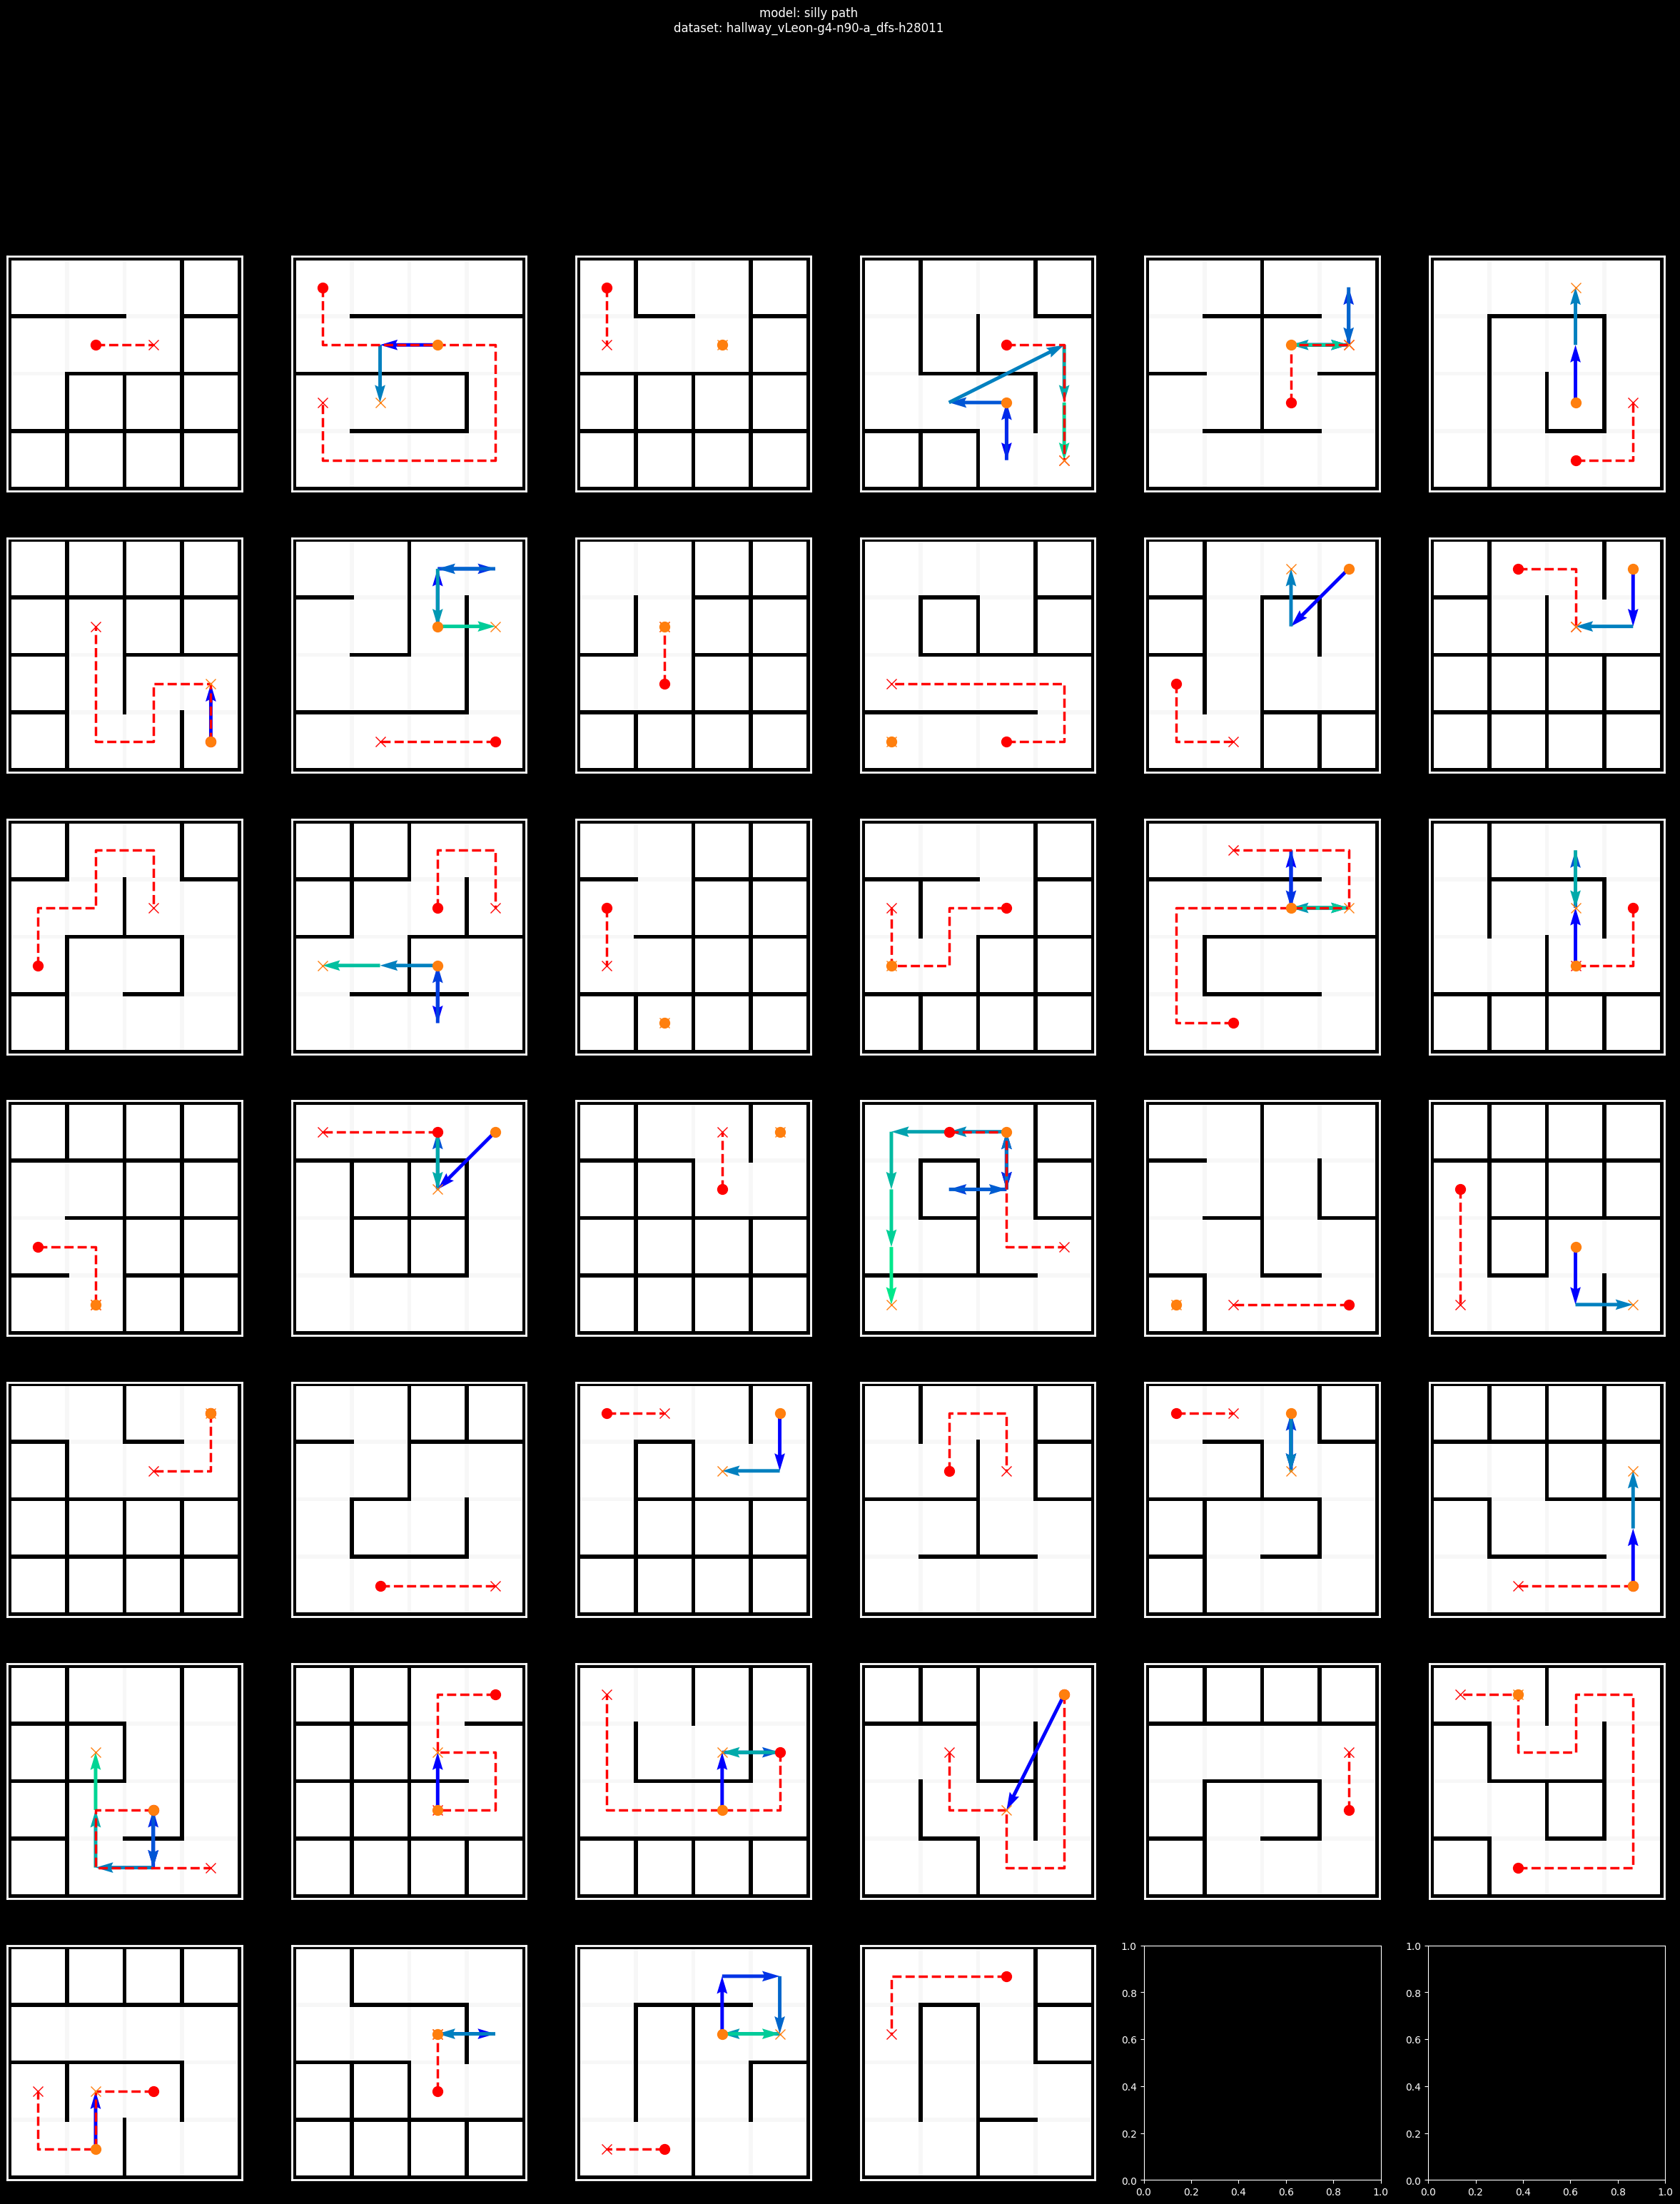

In [23]:
def generate_rollout_plots(
    model,
    dataset: list[MazeDataset],
) -> pd.DataFrame:
    """ Generate rollouts for each model on each dataset and save them to disk """
    from maze_dataset.plotting import MazePlot, PathFormat
    from maze_transformer.evaluation.plotting import plot_predicted_paths

	# for model_path in models_paths:
    print("-"*50)

    # iter over datasets
    model_path = "silly path"
    # for dataset in datasets:
    print(f"rollouts  on {dataset.cfg.to_fname()}")

    plot_predicted_paths(
        model, 
        dataset, 
        n_mazes=40,
        max_new_tokens=50, 
        row_length=6, 
        figsize_scale=5,
        predicted_path_fmt=PathFormat(cmap="winter"),
        show=False,
        print_generations=False,
    )
    plt.suptitle(f"model: {model_path.split('/')[-1]}\ndataset: {dataset.cfg.to_fname()}")
    plt.savefig(f"rollouts/{model_path.split('/')[-1]}.{dataset.cfg.to_fname()}.pdf")
    plt.show()

generate_rollout_plots(
	model=result.model  ,
	dataset=DATASET,
)

# 100.  Messy  evaluation metric print


In [ ]:
evalres =  {'loss': 4.242205619812012, 'node_overlap': {
  "StatCounter": {
    "0.0": 31,
    "0.045454545454545456": 1,
    "0.058823529411764705": 1,
    "0.06666666666666667": 2,
    "0.06896551724137931": 1,
    "0.07142857142857142": 1,
    "0.07692307692307693": 2,
    "0.08333333333333333": 1,
    "0.09090909090909091": 2,
    "0.09523809523809523": 1,
    "0.10526315789473684": 1,
    "0.1111111111111111": 4,
    "0.11538461538461539": 1,
    "0.11764705882352941": 2,
    "0.125": 3,
    "0.13043478260869565": 1,
    "0.13793103448275862": 1,
    "0.14285714285714285": 3,
    "0.14814814814814814": 1,
    "0.15": 2,
    "0.15384615384615385": 2,
    "0.15789473684210525": 1,
    "0.16": 1,
    "0.16666666666666666": 11,
    "0.18181818181818182": 5,
    "0.1875": 1,
    "0.2": 5,
    "0.2222222222222222": 2,
    "0.25": 4,
    "0.2857142857142857": 1,
    "0.3333333333333333": 3,
    "0.4": 2
  },
  "summary": {
    "total_items": 100,
    "n_keys": 32,
    "mode": 0.0,
    "mean": 0.11398383007404629,
    "std": 0.09846646736910215,
    "min": 0.0,
    "q1": 0.0,
    "median": 0.11764705882352941,
    "q3": 0.16666666666666666,
    "max": 0.4
  }
}, 'num_connections_adjacent_lattice': {
  "StatCounter": {
    "0.0": 100
  },
  "summary": {
    "total_items": 100,
    "n_keys": 1,
    "mode": 0.0,
    "mean": 0.0,
    "std": 0.0,
    "min": 0.0,
    "q1": 0.0,
    "median": 0.0,
    "q3": 0.0,
    "max": 0.0
  }
}, 'fraction_connections_adjacent_lattice': {
  "StatCounter": {
    "0.0": 100
  },
  "summary": {
    "total_items": 100,
    "n_keys": 1,
    "mode": 0.0,
    "mean": 0.0,
    "std": 0.0,
    "min": 0.0,
    "q1": 0.0,
    "median": 0.0,
    "q3": 0.0,
    "max": 0.0
  }
}, 'num_connections_adjacent': {
  "StatCounter": {
    "0": 100
  },
  "summary": {
    "total_items": 100,
    "n_keys": 1,
    "mode": 0,
    "mean": 0.0,
    "std": 0.0,
    "min": 0,
    "q1": 0.0,
    "median": 0.0,
    "q3": 0.0,
    "max": 0
  }
}, 'fraction_connections_adjacent': {
  "StatCounter": {
    "0.0": 100
  },
  "summary": {
    "total_items": 100,
    "n_keys": 1,
    "mode": 0.0,
    "mean": 0.0,
    "std": 0.0,
    "min": 0.0,
    "q1": 0.0,
    "median": 0.0,
    "q3": 0.0,
    "max": 0.0
  }
}, 'exact_path_predicted': {
  "StatCounter": {
    "0.0": 100
  },
  "summary": {
    "total_items": 100,
    "n_keys": 1,
    "mode": 0.0,
    "mean": 0.0,
    "std": 0.0,
    "min": 0.0,
    "q1": 0.0,
    "median": 0.0,
    "q3": 0.0,
    "max": 0.0
  }
}, 'solution_length': {
  "StatCounter": {
    "2.0": 10,
    "3.0": 3,
    "4.0": 7,
    "5.0": 12,
    "6.0": 12,
    "7.0": 1,
    "8.0": 3,
    "9.0": 6,
    "10.0": 3,
    "11.0": 6,
    "12.0": 3,
    "13.0": 4,
    "14.0": 3,
    "15.0": 3,
    "16.0": 3,
    "17.0": 3,
    "18.0": 3,
    "19.0": 2,
    "20.0": 2,
    "21.0": 2,
    "22.0": 2,
    "23.0": 1,
    "24.0": 1,
    "25.0": 1,
    "26.0": 1,
    "27.0": 1,
    "29.0": 2
  },
  "summary": {
    "total_items": 100,
    "n_keys": 27,
    "mode": 5.0,
    "mean": 10.45,
    "std": 7.007674364580592,
    "min": 2.0,
    "q1": 5.0,
    "median": 9.0,
    "q3": 15.0,
    "max": 29.0
  }
}, 'streak_length_until_incorrect': {
  "StatCounter": {
    "0.0": 97,
    "1.0": 3
  },
  "summary": {
    "total_items": 100,
    "n_keys": 2,
    "mode": 0.0,
    "mean": 0.03,
    "std": 0.1705872210923198,
    "min": 0.0,
    "q1": 0.0,
    "median": 0.0,
    "q3": 0.0,
    "max": 1.0
  }
}, 'distance_between_end_nodes': {
  "StatCounter": {
    "0.0": 5,
    "1.0": 8,
    "1.4142135623730951": 13,
    "2.0": 15,
    "2.23606797749979": 19,
    "2.8284271247461903": 3,
    "3.0": 7,
    "3.1622776601683795": 5,
    "3.605551275463989": 9,
    "4.0": 5,
    "4.123105625617661": 4,
    "4.242640687119285": 1,
    "4.47213595499958": 4,
    "5.0": 2
  },
  "summary": {
    "total_items": 100,
    "n_keys": 14,
    "mode": 2.23606797749979,
    "mean": 2.452403060471909,
    "std": 1.1729105801330366,
    "min": 0.0,
    "q1": 1.4142135623730951,
    "median": 2.23606797749979,
    "q3": 3.273096063992282,
    "max": 5.0
  }
}, 'corner_jumps': {
  "StatCounter": {
    "0": 69,
    "1": 31
  },
  "summary": {
    "total_items": 100,
    "n_keys": 2,
    "mode": 0,
    "mean": 0.31,
    "std": 0.46249324319388707,
    "min": 0,
    "q1": 0.0,
    "median": 0.0,
    "q3": 1.0,
    "max": 1
  }
}, 'average_predicted_step_size': {
  "StatCounter": {
    "2.27240226919466": 41,
    "2.4524627736864777": 29,
    "2.6057356025279934": 3,
    "2.762511840008253": 2,
    "3.290569415042095": 25
  },
  "summary": {
    "total_items": 100,
    "n_keys": 5,
    "mode": 2.27240226919466,
    "mean": 2.5989637933754177,
    "std": 0.41238750470581587,
    "min": 2.27240226919466,
    "q1": 2.27240226919466,
    "median": 2.4524627736864777,
    "q3": 2.8945262337667135,
    "max": 3.290569415042095
  }
}}

In [ ]:
# a function that takes as input a nested dict and prints all the keys in a nice way
# def print_keys(d: typing.Dict, prefix: str = ""):
#     for k, v in d.items():
#         if isinstance(v, dict):
#             print_keys(v, prefix=f"{prefix}{k}.")
#         else:
#             print(f"{prefix}{k}")

import typing

# def print_keys(d: typing.Dict, prefix: str = "", level: int = 0):
#     indent = "  " * level  # Define the indentation based on the nesting level
#     for k, v in d.items():
#         if isinstance(v, dict):
#             print(f"{indent}{prefix}{k}:")  # Print the current dict key
#             print_keys(v, prefix="", level=level+1)  # Recursively print nested dict
#         else:
#             print(f"{indent}{prefix}{k}")  # Print the current key

def print_keys(d: typing.Dict, prefix: str = " ", level: int = 0):
    indent = "  " * level  # Basic indentation for readability
    marker = "|-" if level > 0 else ""  # Add a marker for nested levels
    for k, v in d.items():
        if isinstance(v, dict):
            print(f"{indent}{marker}{prefix}{k}:")  # Print the current dict key with marker
            # print_keys(v, prefix=prefix, level=level+1)  # Recursively print nested dict
        else:
            # check if k is float (potentially stored as string)
            # try:
            #     float(k)
            #     # k = f"{k:0.2f}"
            #     float_value = float(k)  # Try converting to float
            #     # print(f"{variable} is a float stored as a string.")
            #     # print("it is a float")
            # except ValueError:
                # pass
            print(f"{indent}{marker}{prefix}{k}")  # Print the current key with marker



print_keys(evalres)

 loss
 node_overlap:
 num_connections_adjacent_lattice:
 fraction_connections_adjacent_lattice:
 num_connections_adjacent:
 fraction_connections_adjacent:
 exact_path_predicted:
 solution_length:
 streak_length_until_incorrect:
 distance_between_end_nodes:
 corner_jumps:
 average_predicted_step_size:


In [ ]:
 node_overlap:
 num_connections_adjacent_lattice:
 fraction_connections_adjacent_lattice:
 num_connections_adjacent:
 fraction_connections_adjacent:
 exact_path_predicted:
 solution_length:
 streak_length_until_incorrect:
 distance_between_end_nodes:
 corner_jumps:
 average_predicted_step_size: